## Content
1. Imports and data exploration - (you can skip this)
2. Create the dataset - copied from Bhat, it extracts the features per video per channel and in the end merges everything into one big data structrue to train his GAN model.
3. Extract Labels - here I reconstructed the binary labels, every label gets rounded to 0 if <=5 or 1 if >5
4. Normalize Data - stratified normalization as discussed ie. channel vise

## 1. Imports and data exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis


In [2]:
#this is a dict
raw_data = np.load('data/data_preprocessed_python/s01.dat',allow_pickle=True,encoding='bytes')

In [3]:
raw_data.keys()

dict_keys([b'labels', b'data'])

In [4]:
data = raw_data[b'data']
labels = raw_data[b'labels']

In [5]:
#valance, arousal, dominance, liking
labels[0]

array([7.71, 7.6 , 6.9 , 7.83])

In [6]:
data.shape #shape of data in (video/trial x channel x data) 40 layers, 40 rows, and 8064 columns

(40, 40, 8064)

In [7]:
data[0][0][0] #check an element

0.948231680995192

In [8]:
labels.shape #shape of the labels

(40, 4)

In [9]:
# experiment 1 first eeg channel
data[0][0]
# experiment 1 second eeg channel
# data[b'data'][0][1] 

array([ 0.94823168,  1.65333533,  3.01372577, ..., -2.82648937,
       -4.47722969, -3.67692812])

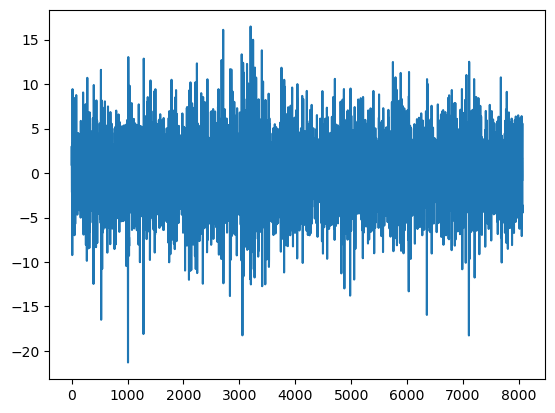

In [10]:
visu = data[0][0]
plt.plot(visu)

/opt/anaconda3/envs/BSc/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


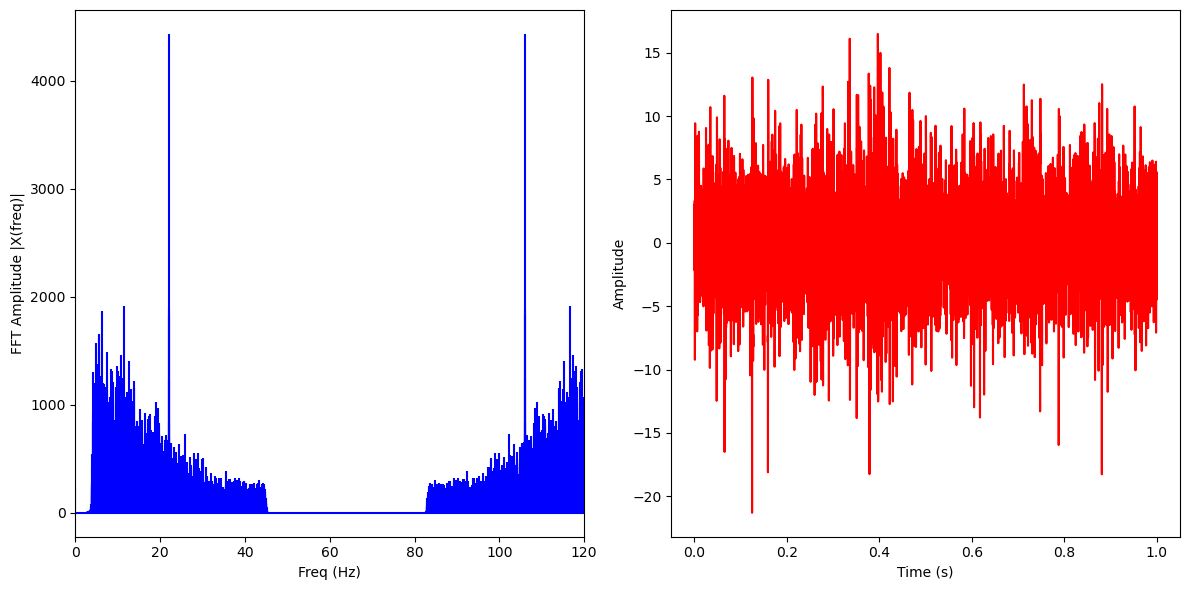

In [11]:
from numpy.fft import fft, ifft
sr = 128
X = fft(visu)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 120)

plt.subplot(122)
t = np.arange(0,1,(1/8064))
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

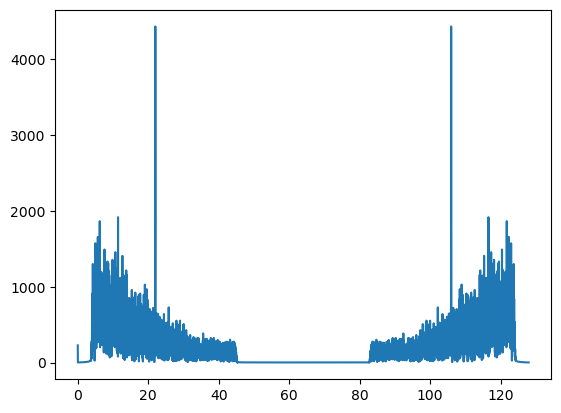

In [12]:
plt.plot(freq, np.abs(fft(visu)))

## 2. Create the dataset 

In [13]:
num_testsub = 32
num_classes = 4
num_channel = 40
num_datapoints = 8064
num_trials = 40
sampling_rate = 128 # 128Hz as given in the data

In [14]:
## from Bhat

# this method extracts the features from the data that is provided
# this method can be used for making a 3d array for training the models.
def getfeatures(arr):
    return [np.mean(arr),
    np.median(arr),
    np.max(arr),
    np.min(arr),
    np.std(arr),
    np.var(arr),
    np.ptp(arr),
    skew(arr),
    kurtosis(arr)]

In [15]:
## from Bhat

# Check that we get from this 240 matrices per person = 6 per video (dimension 40*9) *  40 videos
# in total 240 * 32

# Method 1 
'''
Takes an input file name and gives a 3d numpy array as output
# Method 1 step1
'''
def makeonefile2(fname):
#     newfile = np.array([]).reshape(0,99)
    threed = np.zeros((40,40,99))
    print("Reading the data from the directory..")
#     fdata = open("../samarth/generateddata.dat",'w')  
#     fname = "../data_preprocessed_python/s"+'01'+".dat"     
    f = open(fname, 'rb')                 #Read the file in Binary mode
    x = np.load(f,allow_pickle=True,encoding='bytes')
#    x = pickle.load(f, encoding='latin1') 
    for tr in range(num_trials):
        newfile = np.array([]).reshape(0,99)
        for ch in range(num_channel):
            empty_array = np.array([])
            for i in range(10):
                f = getfeatures(x[b'data'][tr][ch][807*i:807*(i+1)])
                empty_array = np.append(empty_array, f)
                if i== 9:
                    empty_array = np.append(empty_array,getfeatures(x[b'data'][tr][ch][:]))
            newfile = np.vstack((newfile, empty_array))
        threed[tr][:][:]=newfile      
    print("Data processed")
    print("shape of file:",threed.shape)
#     print(newfile)
    return threed

    

In [16]:
## from Bhat

#method 1 step 2
#Pipeline to get the data 
# takes in the number of test subjects as input
def callpipeline(num_testsub):
    for i in range(num_testsub):
            if i < 10:
                name = '%0*d' % (2,i+1)
            else:
                name = i+1
            fname = "data/data_preprocessed_python/s"+str(name)+".dat"  
            print("\n")
            print("Test Subject ------",name)
            outputfile = makeonefile2(fname)
            np.save(str(name), outputfile)

In [17]:
callpipeline(num_testsub)



Test Subject ------ 01
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 02
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 03
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 04
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 05
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 06
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 07
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 08
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 09
Reading the data from the directory..
Data processed
shape of file: (40, 40, 99)


Test Subject ------ 10
Reading the data from

In [18]:
# Loads the saved numpy files that are saved into a dictionary
def loadfiles():
    data_dict = {}
    print("Loading files into data_dict .................")
    for i in range(num_testsub):
                    if i < 10:
                        name = '%0*d' % (2,i+1)
                    else:
                        name = i+1
                    fname = 'data/data_prepared/data/'+str(name) +'.npy'
    #                 print(fname)
                    data_dict["sub%s" %name] = np.load(fname)
    print("Loaded!!!!!") 
    return data_dict

In [19]:
data_dict = loadfiles()

Loading files into data_dict .................
Loaded!!!!!


In [21]:
##### This code creates a single data file that can be used for the model training (whole dataset)
# Method 1 step3
A = np.empty( [1600*32,99] ) #normally it is 40*40*32 rows and 99 columns
files = []
for i in range(num_testsub):
                    if i < 10:
                        name = '%0*d' % (2,i+1)
                    else:
                        name = i+1
                    fname = str(name) +'.npy'
                    files.append(fname)
# print(files)
for index,fname in enumerate(files):
    x = np.load('data/data_prepared/data/'+fname)
    x = x.reshape(40*40,99)
#     print(x)
    A[1600*index:1600*(index+1)] = x
#     print(A[1600*index:1600*(index+1)])
print(A.shape)

(51200, 99)


## 3. Extract Labels

In [22]:
def turn_into_binary(recorded_value):
    if recorded_value <= 5: 
        return 0
    else:
        return 1

In [23]:
# 0 = Valance; 1 = Arousal; 2 = Dominance; 3 = Liking
index = [0, 1, 2, 3]

for ind in index: 
    binary_labels = []
    for i in range(num_testsub):

                if i < 10:
                    name = '%0*d' % (2,i+1)
                else:
                    name = i+1
                # Read in labels of file
                labels = np.load('data/data_preprocessed_python/s'+str(name)+'.dat',allow_pickle=True,encoding='bytes')[b'labels']
                # Temp variable
                rounded_labels = np.empty(40)
                # round the values and save them
                for j in range(labels.shape[0]):
                    binary_value = turn_into_binary(labels[j][ind])
                    rounded_labels[j] = binary_value
                # Append to global list
                binary_labels = np.append(binary_labels, rounded_labels,axis=0) 

    np.save('data/data_prepared/labels/label_class_'+str(ind)+'.npy', binary_labels)            
            

In [28]:
binary_labels.shape

(1280,)

In [ ]:
#Load the labels now    
valence = np.load('data/data_prepared/labels/label_class_0.npy')
arousal = np.load('data/data_prepared/labels/label_class_1.npy')
dominance = np.load('data/data_prepared/labels/label_class_2.npy')
liking = np.load('data/data_prepared/labels/label_class_3.npy')

In [ ]:
test = arousal[440:480]
print(len(test))
print(test)

In [ ]:
labels2 = np.load('data/data_preprocessed_python/s12.dat',allow_pickle=True,encoding='bytes')[b'labels']
labels2

## 4. Normalize Data 

In [14]:
num_videos = 40
num_channels = 40
num_features = 99

counter = 0
for sub in data_dict.keys():
    for i in range(num_channels):
        for j in range(num_features):
            channel_values = []
            # data_dict[video][channel][99 data]
            # [0][0][0] --> [1][0][0] --> [2][0][0] .... [0][0][1] --> [1][0][1] --> [2][0][1]
            # .... ---> [0][0][99] --> [0][1][0] --> [1][1][0]
            for k in range(num_videos):
                channel_values.append(data_dict[sub][k][i][j])
            # get min and max
            min_channel = np.min(channel_values)
            max_channel = np.max(channel_values)
            # go over each value one more time and normalize it
            for l in range(num_videos):
                x = data_dict[sub][l][i][j] 
                data_dict[sub][l][i][j] = (x - min_channel) / (max_channel - min_channel)
                if counter <= 40:
                    print(" original ",x)
                    print(" new ",data_dict[sub][l][i][j], " k ",l, " i ",i," j ",j)
                counter = counter + 1
            channel_values.clear()

 original  -0.029226063547699566
 new  0.2963309683219099  k  0  i  0  j  0
 original  -0.048606218951412566
 new  0.18731470865018868  k  1  i  0  j  0
 original  0.05329227715616479
 new  0.7605089209986231  k  2  i  0  j  0
 original  -0.02421026177223174
 new  0.3245456001153949  k  3  i  0  j  0
 original  -0.04981391251214841
 new  0.18052125255665186  k  4  i  0  j  0
 original  -0.00523438358258717
 new  0.4312877402648444  k  5  i  0  j  0
 original  -0.04360706357403305
 new  0.21543570197593226  k  6  i  0  j  0
 original  -0.05960854030111124
 new  0.12542501291427746  k  7  i  0  j  0
 original  -0.06454706834002083
 new  0.09764505739427698  k  8  i  0  j  0
 original  -0.029732007919551273
 new  0.29348495589980805  k  9  i  0  j  0
 original  0.01853185922668211
 new  0.5649763946406545  k  10  i  0  j  0
 original  -0.08190573018004399
 new  0.0  k  11  i  0  j  0
 original  -0.037950516629240205
 new  0.24725462074789806  k  12  i  0  j  0
 original  -0.02310942693430

In [11]:
values = []
for video in range(40):
    print(data_dict['sub01'][video][0][0])
    values.append(data_dict['sub01'][video][0][0])
print("min ",np.min(values))
print("max ",np.max(values))

-0.029226063547699566
-0.048606218951412566
0.05329227715616479
-0.02421026177223174
-0.04981391251214841
-0.00523438358258717
-0.04360706357403305
-0.05960854030111124
-0.06454706834002083
-0.029732007919551273
0.01853185922668211
-0.08190573018004399
-0.037950516629240205
-0.02310942693430106
0.07362403133056496
0.00835214915060532
0.0039842871324803205
0.0012359592824429681
-0.06600176487683548
-0.028922348538814573
-0.023487593866054455
-0.0237901510740017
-0.0628042159341865
-0.00944722294950153
0.014854439694268744
-0.054860105587383634
-0.027081887174877965
0.09586734203938571
-0.011552127767474574
-0.012448820811805782
-0.02701934141234445
0.011849892199168759
0.0001962850089392007
0.008591294527014362
0.01854360247000838
0.005892144426649304
0.047870285688247506
0.06174927858689093
0.06253084690989016
0.039995214178805145
min  -0.08190573018004399
max  0.09586734203938571


In [9]:
df = []
for video in range(40):
    df.append(data_dict['sub01'][video][0][0])
df

[0.2963309683219099,
 0.18731470865018868,
 0.7605089209986231,
 0.3245456001153949,
 0.18052125255665186,
 0.4312877402648444,
 0.21543570197593226,
 0.12542501291427746,
 0.09764505739427698,
 0.29348495589980805,
 0.5649763946406545,
 0.0,
 0.24725462074789806,
 0.3307379599828775,
 0.8748780654397124,
 0.5077140097980744,
 0.4831441356118779,
 0.4676843822548283,
 0.08946217278383899,
 0.29803941046724286,
 0.3286107146862073,
 0.32690878534353496,
 0.10744886167169354,
 0.40758989157314635,
 0.5442903622370843,
 0.1521356651769919,
 0.3083922796670555,
 1.0,
 0.39574948857119496,
 0.39070545668753376,
 0.3087441088937919,
 0.5273893352278227,
 0.4618360596684893,
 0.5090592381469092,
 0.5650424521328251,
 0.4938761169538782,
 0.7300094117072227,
 0.8080808132157271,
 0.81247725140089,
 0.6857109619413213]

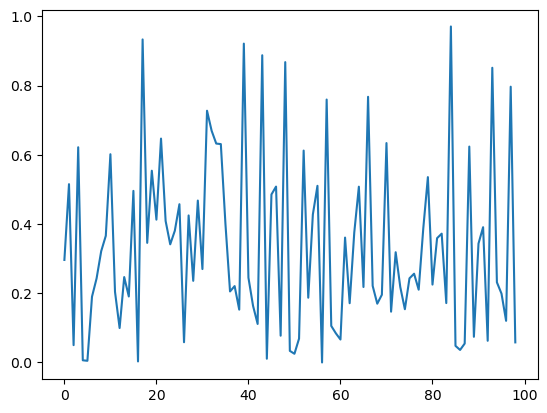

In [15]:
plt.plot(data_dict['sub01'][0][0])